In [22]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras, feature_column
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds

# from IPython.core.interactiveshell import InteractiveShell


In [23]:
# 配置项
# 这个要放到设置中文之前否则还是小方框
plt.style.use("seaborn")

# 指定默认字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# #全部行都能输出
# InteractiveShell.ast_node_interactivity = "all"

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [5]:
# 下载数据
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
dataset

W0821 18:31:29.980421 4567512512 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /Users/JQC/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


W0821 18:33:14.540151 4567512512 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


{'test': <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'train': <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [8]:
# 划分训练集和测试集
train_dataset, test_dataset = dataset['train'], dataset['test']
# 无重复的单词
tokenizer = info.features['text'].encoder
print ('Vocabulary size: {}'.format(tokenizer.vocab_size))


Vocabulary size: 8185


In [16]:
sample_string = 'TensorFlow is cool.'

# 编码
tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

# 解码
original_string = tokenizer.decode(tokenized_string)
print('decode string is {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [6307, 2327, 4043, 4265, 9, 2724, 7975]
decode string is TensorFlow is cool.


In [18]:
# The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.
# 如果单词不在字典中 tokenizer会把单词拆解成子单词进行编码
for ts in tokenized_string:
    print('{}......{}'.format(ts, tokenizer.decode([ts])))

6307......Ten
2327......sor
4043......Fl
4265......ow 
9......is 
2724......cool
7975.......


In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

In [20]:
# 建立模型
model = keras.Sequential([
    keras.layers.Embedding(tokenizer.vocab_size, 64), # 单词嵌入层
    keras.layers.Bidirectional(keras.layers.LSTM(64)), # 这一层经常和递归神经网络一起使用
    keras.layers.Dense(64, activation='relu'), # 隐藏层
    keras.layers.Dense(1, activation='sigmoid') # 输出层
])

# 编译模型
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
# 训练模型 这个训练会花很长时间 这个要注意
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


W0821 19:02:48.768872 4567512512 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


391/391 [==============================] - 1232s 3s/step - loss: 0.5884 - accuracy: 0.6738 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 1022s 3s/step - loss: 0.4002 - accuracy: 0.8287 - val_loss: 0.4068 - val_accuracy: 0.8298
Epoch 3/10
391/391 [==============================] - 999s 3s/step - loss: 0.3230 - accuracy: 0.8736 - val_loss: 0.4042 - val_accuracy: 0.8348
Epoch 4/10
391/391 [==============================] - 1074s 3s/step - loss: 0.2520 - accuracy: 0.9038 - val_loss: 0.3997 - val_accuracy: 0.8271
Epoch 5/10
391/391 [==============================] - 1070s 3s/step - loss: 0.2033 - accuracy: 0.9251 - val_loss: 0.4179 - val_accuracy: 0.8388
Epoch 6/10
391/391 [==============================] - 2761s 7s/step - loss: 0.1823 - accuracy: 0.9326 - val_loss: 0.4671 - val_accuracy: 0.8286
Epoch 7/10
391/391 [==============================] - 1126s 3s/step - loss: 0.1482 - accuracy: 0.9474 - val_loss: 0.4865 - val_accuracy: 0.8

In [25]:
# 评估模型
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 283s 723ms/step - loss: 0.5696 - accuracy: 0.8081Test Loss: 0.5696338625515208
Test Accuracy: 0.8081200122833252


In [26]:
# 预测这一块不是很明白 ???
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sentence, pad):
  tokenized_sample_pred_text = tokenizer.encode(sentence)

  if pad:
    tokenized_sample_pred_text = pad_to_size(tokenized_sample_pred_text, 64)

  predictions = model.predict(tf.expand_dims(tokenized_sample_pred_text, 0))

  return (predictions)

In [27]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)


[[0.53845]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.15619895]]


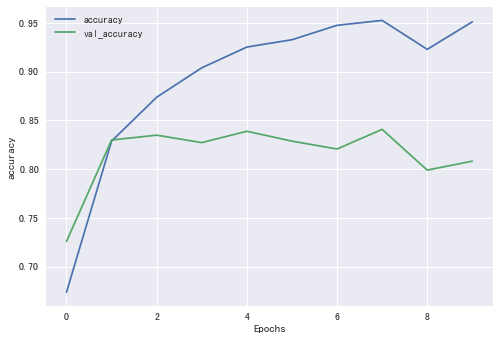

In [29]:
plot_graphs(history, 'accuracy')


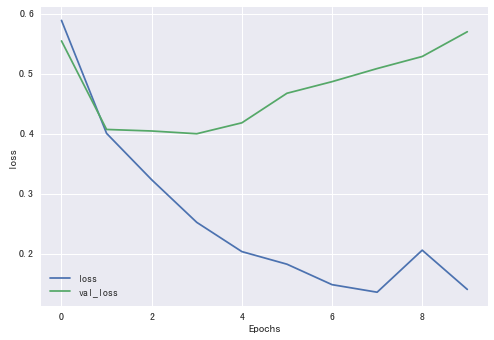

In [30]:
plot_graphs(history, 'loss')


In [31]:
# 两层或者多层LSTM 
# 建立模型
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 编译
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset)


Epoch 1/10
     29/Unknown - 131s 5s/step - loss: 0.6935 - accuracy: 0.5000

KeyboardInterrupt: 

In [ ]:
# 评估模型
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# 再次预测
# predict on a sample text without padding.
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

In [ ]:
plot_graphs(history, 'accuracy')


In [ ]:
plot_graphs(history, 'loss')
